In [1]:
import os
import pyhf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import interpolate

# Set constraints of $\kappa_\lambda$

In [2]:
# negative log likelyhood
def NLL(N_sig, N_bkg, N_obv=None):
    N_pre = N_sig + N_bkg
    if not N_obv:
        N_obv = N_bkg
    
    return -2 * (-N_pre + N_obv * np.log(N_pre)).sum()

def find_root(f, x0, x1):
    if f(x0) * f(x1) > 0:
        print('Wrong Guess')
    else:
        tol = 1e-12
        while abs(f(x0)) > tol:
            c = (x0 + x1)/2
            if f(c) * f(x0) > 0:
                x0, x1 = c, x1
            else:
                x0, x1 = x0, c
        return x0

In [3]:
n_bin = 10
hist_range = [200, 1000]
L = 300

In [4]:
def get_NLL_info(bkg_path, sig_paths, n_bin=10, hist_range=[200,1000], L=139):
    # 0: cross-section
    # 1: total number of events
    # 2: kappa
    # 3: mhh
    
    # results after selection
    results_b = np.load(bkg_path, allow_pickle=True)
    N_bkg, _ = np.histogram(results_b[3], bins=n_bin, range=hist_range, 
                                weights=1/results_b[1]*results_b[0]*L*np.ones_like(results_b[3]))

    kappas, NLLs = [], []
    for path in sig_paths:
        results_s = np.load(path, allow_pickle=True)
        kappas.append(results_s[2])
        N_sig, _ = np.histogram(results_s[3], bins=n_bin, range=hist_range, 
                                weights=1/results_s[1]*results_s[0]*L*np.ones_like(results_s[3]))
        
        NLLs.append(NLL(N_sig, N_bkg))
    
    results = {
        'kappas': kappas,
        'NLLs': NLLs,
    }
    
    return results

In [5]:
def plot_log_likelihood_ratio(results, title, save_path=None):
    kappas = results['kappas']
    NLLs = results['NLLs']
    
    NLLs = np.array(NLLs)
    LL_r = NLLs - NLLs.min()

    x = np.array(kappas)
    arg = x.argsort()
    x = x[arg]
    y = LL_r[arg]

    # interpolate
    f = interpolate.UnivariateSpline(x, y, s=0, k=3)

    x_new = np.linspace(x.min(), x.max(), 100)
    y_new = f(x_new)
    

    def g(x):
        return f(x) - 2 * 1.96

    r1 = find_root(g, -10, 3)
    r2 = find_root(g, 15, 3)
    
    fig, ax = plt.subplots(1, 1, figsize =(6, 5))
    ax.scatter(kappas, LL_r)
    ax.plot(x_new, y_new, label='Expected')
    ax.plot(x_new, np.ones_like(x_new)*4, label='$\pm 2 \sigma$')
    ax.set_xlabel('$\kappa_\lambda$')
    ax.set_ylabel('$-2\Delta\ln(L)$')
    ax.set_title(title)
    if r1 and r2:
        ax.text(0, 15, f'Expected $2\sigma$ constraints:\n $\kappa_\lambda\in[{r1:.2f},{r2:.2f}]$')

    ax.legend()
    if save_path:
        plt.savefig(save_path, facecolor='White', dpi=300, bbox_inches='tight')
    plt.show()
    
    return r1, r2

## CLs method

In [6]:
def get_upperlimit_info(bkg_path, sig_paths, n_bin=10, hist_range=[200,1000], L=139, th=0):
    # Background    
    # results after selection
    results_b = np.load(bkg_path, allow_pickle=True)  
    N_bkg, _ = np.histogram(results_b[3], bins=n_bin, range=hist_range, 
                                weights=1/results_b[1]*results_b[0]*L*np.ones_like(results_b[3]))
    
    # Scan kappa
    kappas, exp_lims, xections = [], [], []      
    for path in tqdm(sig_paths):
        results_s = np.load(path, allow_pickle=True)
        xections.append(results_s[0])
        xection = 100
        kappas.append(results_s[2])       
        N_sig, _ = np.histogram(results_s[3], bins=n_bin, range=hist_range, 
                                weights=1/results_s[1]*xection*L*np.ones_like(results_s[3]))
        
        
        model = pyhf.simplemodels.uncorrelated_background(
            signal=list(N_sig), bkg=list(N_bkg), bkg_uncertainty=[0]*n_bin
        )

        poi_values = np.linspace(0.05, 10, 100)
        obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
            list(N_bkg) + model.config.auxdata, model, poi_values, level=0.05, return_results=True
        )
        exp_lims.append(exp_limits)
        
    results = {
        'kappas': kappas,
        'Expected limits': exp_lims,
        'Cross sections': xections,
    }
    
    return results

In [7]:
def plot_xection_upperlimit(results, title, save_path=None):
    kappas = results['kappas']
    exp_lims = results['Expected limits']
    theory_pred = results['Cross sections']
    
    x = np.array(kappas)
    x_new = np.linspace(x.min(), x.max(), 100)
    
    expected_lim = np.array([exp_limits[2] for exp_limits in exp_lims]) * 100 / 0.582**2
    # interpolate expeacted upper limit
    f_exp2 = interpolate.UnivariateSpline(x, expected_lim, s=0, k=2)
    y_exp2 = f_exp2(x_new)
    
    # Theory prediction (the cross-sections from MadGraph)
    theory_pred = np.array(theory_pred) / 0.582**2
    f_theory = interpolate.UnivariateSpline(x, theory_pred, s=0, k=2)
    y_theory = f_theory(x_new)
    
    def g(x):
        return f_exp2(x) - f_theory(x)

    r1 = find_root(g, -10, 2)
    r2 = find_root(g, 15, 2)
    
    fig, ax = plt.subplots(1, 1, figsize =(6, 5))
    ax.scatter(kappas, expected_lim)
    ax.scatter(kappas, theory_pred)
    ax.plot(x_new, y_exp2, label='Expected Limit 95%')
    ax.plot(x_new, y_theory, label='Theory Prediction')

    ax.set_xlabel('$\kappa_\lambda$')
    ax.set_ylabel('95% CL limit on $\sigma$ [fb]')
    ax.set_title(title)
    ax.set_ylim([1e0, 1e4])
    ax.set_yscale('log')

    ax.legend()
    
    if r1 and r2:
        ax.text(-10, 5, f'Expected: $\kappa_\lambda\in[{r1:.2f},{r2:.2f}]$')
    if save_path:
        plt.savefig(save_path, facecolor='White', dpi=300, bbox_inches = 'tight')
    plt.show()
    
    return r1, r2

In [8]:
def write_results_to_csv(pairing_method, selection_method, LL_results=[None,None], CLs_results=[None,None]):
   # Write results
    file_name = 'kappa_constraints_results.csv'
    df = pd.DataFrame({'Pairing method': [pairing_method],
                    'Selection method': [selection_method],
                    'log likelihood lower': [LL_results[0]],
                    'log likelihood upper': [LL_results[1]],
                    'CLs lower': [CLs_results[0]],
                    'CLs upper': [CLs_results[1]],
                    })
    if os.path.isfile(file_name):
        training_results_df = pd.read_csv(file_name)
        pd.concat([training_results_df, df], ignore_index=True).to_csv(file_name, index=False)
    else:
        df.to_csv(file_name, index=False) 

# Cuts based Selection 

## $\text{min-}\Delta R$ 

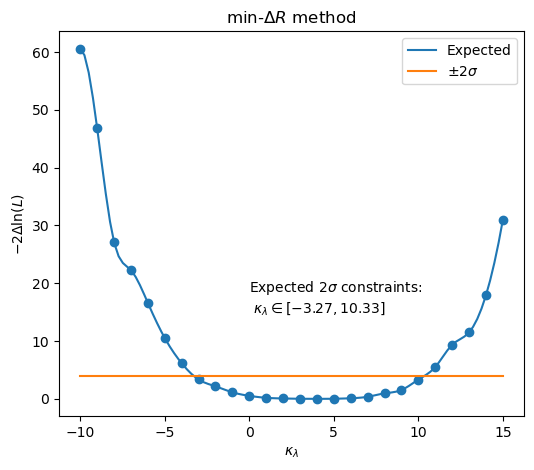

100%|██████████| 26/26 [00:38<00:00,  1.49s/it]


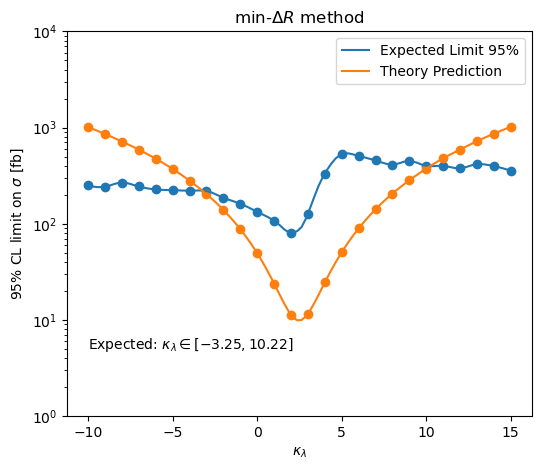

In [9]:
bkg_path = '../Sample/Kappa_constraints/cuts_base_selection/min_dR-bkg.npy'
sig_paths = [f'../Sample/Kappa_constraints/cuts_base_selection/min_dR-kappa{i}.npy' for i in range(-10,16,1)]

L = 300
min_dR_LLr_results = get_NLL_info(bkg_path=bkg_path, sig_paths=sig_paths, L=L)
LL = plot_log_likelihood_ratio(min_dR_LLr_results, title='min-$\Delta R$ method')

min_dR_results = get_upperlimit_info(bkg_path=bkg_path, sig_paths=sig_paths, L=L)
CLs = plot_xection_upperlimit(min_dR_results, title='min-$\Delta R$ method', save_path=None)

# write_results_to_csv(pairing_method='min-dR', selection_method='cut based', LL_results=LL, CLs_results=CLs)

## Mixing $\kappa_\lambda$ SPANet

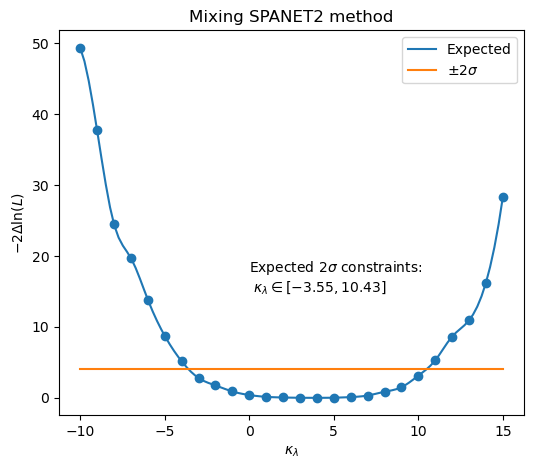

100%|██████████| 26/26 [00:42<00:00,  1.63s/it]


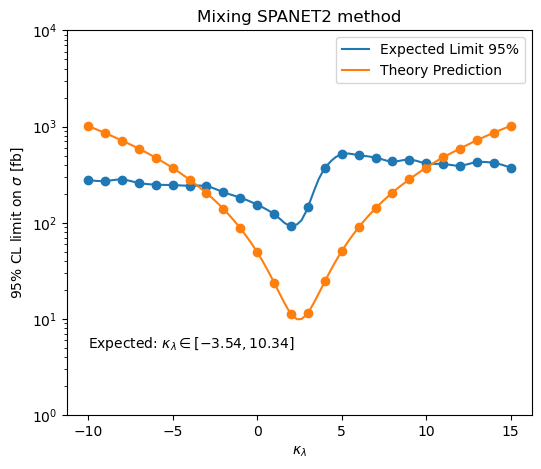

In [10]:
bkg_path = '../Sample/Kappa_constraints/cuts_base_selection/mix-SPANET2-bkg.npy'
sig_paths = [f'../Sample/Kappa_constraints/cuts_base_selection/mix-SPANET2-kappa{i}.npy' for i in range(-10,16)]

L = 300

mix_SPANET2_LLr_results = get_NLL_info(bkg_path=bkg_path, sig_paths=sig_paths, L=L)
LL = plot_log_likelihood_ratio(mix_SPANET2_LLr_results, title='Mixing SPANET2 method')

mix_SPANET2_results = get_upperlimit_info(bkg_path=bkg_path, sig_paths=sig_paths, L=L)
CLs = plot_xection_upperlimit(mix_SPANET2_results, title='Mixing SPANET2 method', save_path=None)

# write_results_to_csv(pairing_method='Mixing SPANET2', selection_method='cut based', LL_results=LL, CLs_results=CLs)

# DNN selection

## $\text{min-}\Delta R$ pairing best HP

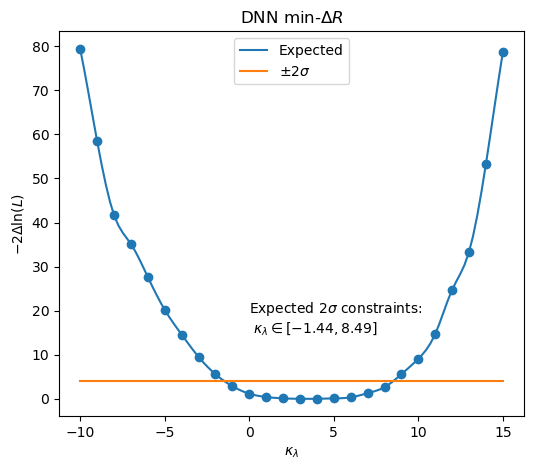

100%|██████████| 26/26 [00:38<00:00,  1.50s/it]


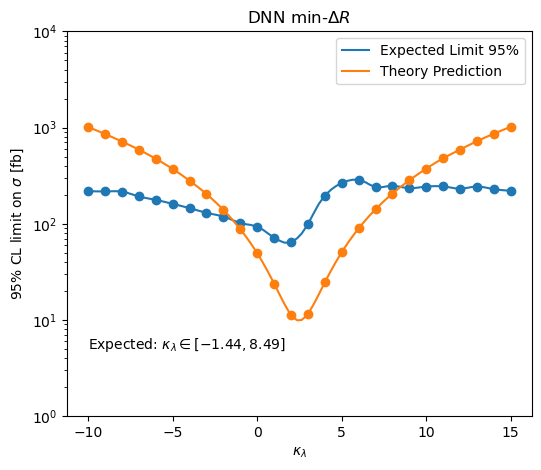

In [11]:
bkg_path = '../Sample/Kappa_constraints/DNN_selection/min-dR-best-hp-bkg.npy'
sig_paths = [f'../Sample/Kappa_constraints/DNN_selection/min-dR-best-hp-kappa{i}.npy' for i in range(-10,16)]

L = 300

min_dR_DNN_LLr_results = get_NLL_info(bkg_path=bkg_path, sig_paths=sig_paths, L=L)
LL = plot_log_likelihood_ratio(min_dR_DNN_LLr_results, title='DNN min-$\Delta R$', save_path='./figures/log_likelihood_ratio_kappa-min_dR_DNN_selection.pdf')

min_dR_DNN_results = get_upperlimit_info(bkg_path=bkg_path, sig_paths=sig_paths, L=L)
CLs = plot_xection_upperlimit(min_dR_DNN_results, title='DNN min-$\Delta R$', save_path='./figures/CLs_upper_limit-nonresonant-min_dR_DNN_selection.pdf')

# write_results_to_csv(pairing_method='Mixing SPANET2', selection_method='SPANET2 selection', LL_results=LL, CLs_results=CLs)

## Mixing $\kappa_\lambda$ SPANet Pairing best HP

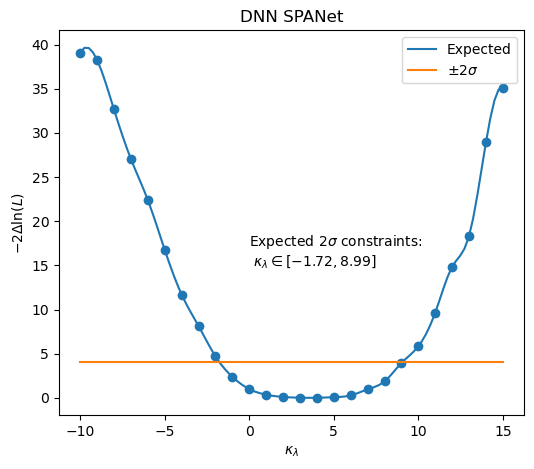

100%|██████████| 26/26 [00:39<00:00,  1.50s/it]


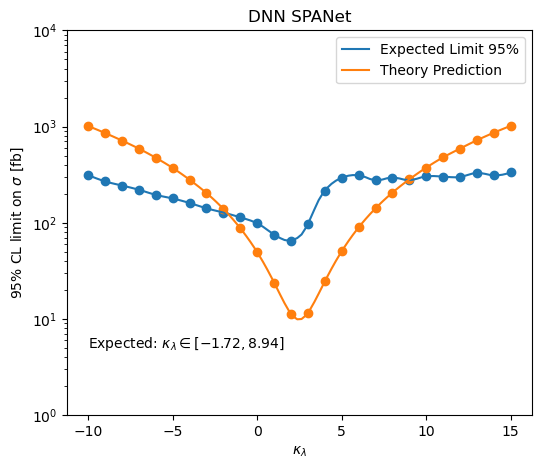

In [12]:
bkg_path = '../Sample/Kappa_constraints/DNN_selection/mix-class-SPANET2-best-hp-bkg.npy'
sig_paths = [f'../Sample/Kappa_constraints/DNN_selection/mix-class-SPANET2-best-hp-kappa{i}.npy' for i in range(-10,16)]

L = 300

mix_class_SPANET2_DNN_LLr_results = get_NLL_info(bkg_path=bkg_path, sig_paths=sig_paths, L=L)
LL = plot_log_likelihood_ratio(mix_class_SPANET2_DNN_LLr_results, title='DNN SPANet', save_path='./figures/log_likelihood_ratio_kappa-SPANet_DNN_selection.pdf')

mix_class_SPANET2_DNN_results = get_upperlimit_info(bkg_path=bkg_path, sig_paths=sig_paths, L=L)
CLs = plot_xection_upperlimit(mix_class_SPANET2_DNN_results, title='DNN SPANet', save_path='./figures/CLs_upper_limit-nonresonant-SPANet_DNN_selection.pdf')

# write_results_to_csv(pairing_method='Mixing SPANET2', selection_method='SPANET2 selection', LL_results=LL, CLs_results=CLs)

# SPANet Selection

## Mixing $\kappa_\lambda$ best HP SPANet Selection

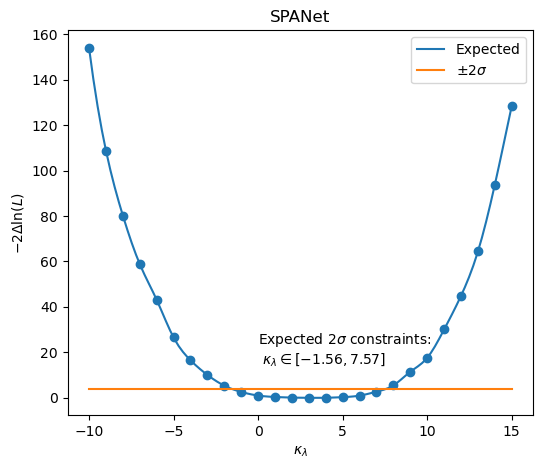

100%|██████████| 26/26 [00:39<00:00,  1.51s/it]


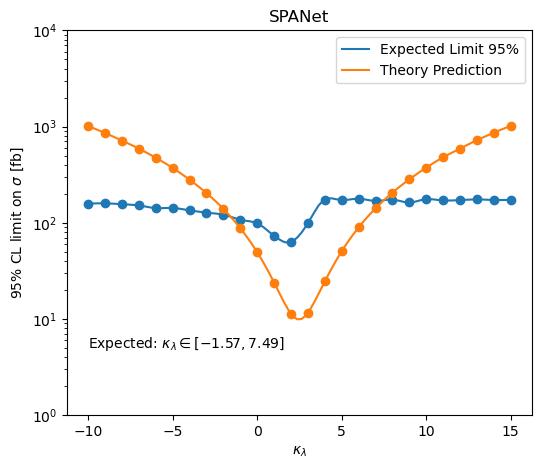

In [13]:
bkg_path = '../Sample/Kappa_constraints/SPANET2_selection/mix-best-hp-SPANET2-bkg.npy'
sig_paths = [f'../Sample/Kappa_constraints/SPANET2_selection/mix-best-hp-SPANET2-kappa{i}.npy' for i in range(-10,16)]

L = 300

mix_SPANET2_hp_LLr_results = get_NLL_info(bkg_path=bkg_path, sig_paths=sig_paths, L=L)
LL = plot_log_likelihood_ratio(mix_SPANET2_hp_LLr_results, title='SPANet', save_path='./figures/log_likelihood_ratio_kappa-SPANet_selection.pdf')

mix_hp_SPANET2_results = get_upperlimit_info(bkg_path=bkg_path, sig_paths=sig_paths, L=L)
CLs = plot_xection_upperlimit(mix_hp_SPANET2_results, title='SPANet', save_path='./figures/CLs_upper_limit-nonresonant-SPANet_selection.pdf')

# write_results_to_csv(pairing_method='Mixing SPANET2', selection_method='SPANET2 selection', LL_results=LL, CLs_results=CLs)

# Summary

In [14]:
def get_interpolate(x, y):
    x = np.array(x)
    y = np.array(y)
    
    arg = x.argsort()
    x = x[arg]
    y = y[arg]

    # interpolate
    f = interpolate.UnivariateSpline(x, y, s=0, k=2)

    x_new = np.linspace(x.min(), x.max(), 100)
    y_new = f(x_new)
    
    return x_new, y_new

def get_log_interpolate(x, y):
    x = np.array(x)
    y = np.log10(np.array(y))

    x_, y_ = get_interpolate(x, y)

    x_new = x_
    y_new = np.power(10.0, y_)
    
    return x_new, y_new

def plot_upperlimit(results, title, linestyle='-'):
    kappas = results['kappas']
    exp_lims = results['Expected limits']

    expected_lim = np.array([exp_limits[2] for exp_limits in exp_lims]) * 100 / 0.582**2


    x, y = get_log_interpolate(kappas, expected_lim)

    ax.plot(x, y, label=title, linestyle=linestyle)

def plot_LLr(results, title, linestyle='-'):
    kappas = results['kappas']
    NLLs = np.array(results['NLLs'])
    LL_r = NLLs - NLLs.min()

    x, y = get_interpolate(kappas, LL_r)
    ax.plot(x, y, label=title, linestyle=linestyle)

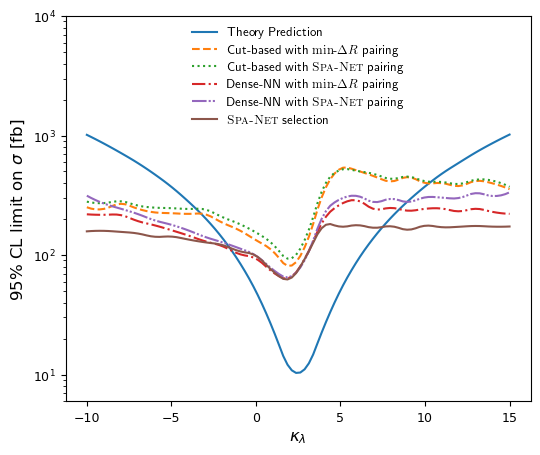

In [15]:
results = min_dR_DNN_results
kappas = results['kappas']

theory_pred = results['Cross sections']
theory_pred = np.array(theory_pred) / 0.582**2
x, y_theory = get_log_interpolate(kappas, theory_pred)


fig, ax = plt.subplots(1, 1, figsize =(6, 5))
ax.plot(x, y_theory, label='Theory Prediction')

plot_upperlimit(min_dR_results, 'Cut-based with $\\mathrm{min}$-$\\Delta R$ pairing', linestyle='--')
plot_upperlimit(mix_SPANET2_results, 'Cut-based with $\\textsc{Spa-Net}$ pairing', linestyle=':')

plot_upperlimit(min_dR_DNN_results, 'Dense-NN with $\\mathrm{min}$-$\\Delta R$ pairing', linestyle='-.')
plot_upperlimit(mix_class_SPANET2_DNN_results, 'Dense-NN with $\\textsc{Spa-Net}$ pairing', linestyle=(0, (7, 1, 1, 1, 1, 1)))

plot_upperlimit(mix_hp_SPANET2_results, '$\\textsc{Spa-Net}$ selection', linestyle='-')

# mix_SPANET2_results

ax.set_xlabel('$\kappa_\lambda$', fontsize=12)
ax.set_ylabel('95% CL limit on $\sigma$ [fb]', fontsize=12)
ax.set_title('')
ax.set_ylim([6, 1e4])
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=9)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
ax.legend(frameon=False, fontsize=9, loc='upper center')
plt.rcParams['text.usetex'] = False

plt.savefig('./figures/CLs_upper_limit-nonresonant.pdf', facecolor='White', dpi=300, bbox_inches='tight')
plt.show()

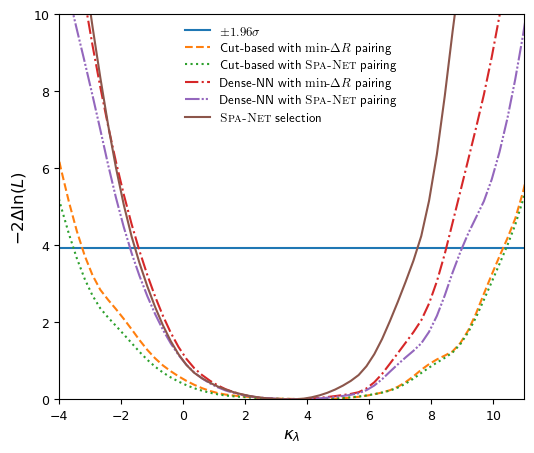

In [16]:
results = min_dR_DNN_results
kappas = results['kappas']

x = np.array(kappas)
arg = x.argsort()
x = x[arg]
x_new = np.linspace(x.min(), x.max(), 100)

fig, ax = plt.subplots(1, 1, figsize =(6, 5))

ax.plot(x_new, np.ones_like(x_new)*2*1.96, label='$\pm 1.96 \sigma$')

plot_LLr(min_dR_LLr_results, 'Cut-based with $\\mathrm{min}$-$\\Delta R$ pairing', linestyle='--')
plot_LLr(mix_SPANET2_LLr_results, 'Cut-based with $\\textsc{Spa-Net}$ pairing', linestyle=':')

plot_LLr(min_dR_DNN_LLr_results, 'Dense-NN with $\\mathrm{min}$-$\\Delta R$ pairing', linestyle='-.')
plot_LLr(mix_class_SPANET2_DNN_LLr_results, 'Dense-NN with $\\textsc{Spa-Net}$ pairing', linestyle=(0, (7, 1, 1, 1, 1, 1)))

plot_LLr(mix_SPANET2_hp_LLr_results, '$\\textsc{Spa-Net}$ selection', linestyle='-')


ax.set_xlabel('$\kappa_\lambda$', fontsize=12)
ax.set_ylabel('$-2\Delta\ln(L)$', fontsize=12)
ax.set_title('')
ax.set_xlim([-4, 11])
ax.set_ylim([0, 10])
ax.tick_params(axis='both', which='major', labelsize=9)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
ax.legend(frameon=False, fontsize=9, loc='upper center')
plt.rcParams['text.usetex'] = False

plt.savefig('./figures/log_likelihood_ratio_kappa.pdf', facecolor='White', dpi=300, bbox_inches='tight')
plt.show()